# Random polymer
This example shows you how to run a simple polymer simulation in hoomdd.

Here is a script that generates a system of bead-spring polymers that self-assemble into a hex phase when run for a few million time steps. The polymers are A6B7A6 block copolymers in an implicit solvent. The script also shows a few examples of how writing python code in the script can be handy: here the concentration phi_P is a parameter and math operations are performed to calculate the length of the box.

For more information on the model in this script, see
"Micellar crystals in solution from molecular dynamics simulations"
J. Chem. Phys. 128, 184906 (2008); DOI:10.1063/1.2913522
http://link.aip.org/link/?JCPSA6/128/184906/1

Any of the polymer systems in the paper could be easily run just by changing a few parameters in this script.
from: https://lost-contact.mit.edu/afs//umich.edu/user/j/o/joaander/Public/hoomd-web/doc/page_example_scripts.html

## Initialize
First import hoomd and associated libraries and then initialize.  If no mode is given then the fastest processor cpu or gpu will be selected automatically.

In [1]:
import hoomd
from hoomd import *
from hoomd import md
from hoomd import deprecated
#context.initialize();
hoomd.context.initialize("--mode=cpu");
#hoomd.context.initialize("--mode=gpu");

HOOMD-blue 2.2.4-unknown CUDA (8.0) DOUBLE HPMC_MIXED SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX AVX2 
Compiled: 03/11/2018
Copyright 2009-2017 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): NVIDIA driver not installed or is too old, ignoring any GPUs in the system.
HOOMD-blue is running on the CPU


## Import other libraries and define parameters

In [2]:
#import math
import math
# parameters (polymer physics)
phi_P = 0.25 # this has to do with how good of a solvent the polymer is in and is only used to calculate the box size below
n_poly = 1 # n_poly in the number of polymers in the simulation
n_beads = 100

## Define the polymer

In [3]:
# This polymer can be made up of two different types A and B.  It's called a block copolymer.
polymer1 = dict(bond_len=1.2, type=['B']*1 + ['A']*n_beads + ['B']*1,bond="linear", count=n_poly)
# perform some simple math to find the length of the box
N = len(polymer1['type']) * polymer1['count']
# generate the polymer system
system=deprecated.init.create_random_polymers(box=data.boxdim(volume=100*math.pi * N / (6.0 * phi_P)), polymers=[polymer1],separation=dict(A=0.35, B=0.35)
                                              ,seed=1234)


notice(2): Group "all" created containing 102 particles


## Setup the bonds and force fields

In [4]:
# force field setup
harmonic = md.bond.harmonic()
harmonic.bond_coeff.set('polymer', k=330.0, r0=0.84)
nl = md.nlist.cell();
lj = md.pair.lj(r_cut=3.0,nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0, alpha=0.0)
lj.pair_coeff.set('A', 'B', epsilon=1.0, sigma=1.0, alpha=0.0)
lj.pair_coeff.set('B', 'B', epsilon=200.0, sigma=1.0, alpha=1.0)

## Integrate the simulation

In [5]:
import numpy
import math
# integrate NVT for a bunch of time steps
all = group.all()
md.integrate.mode_standard(dt=0.005)
md.integrate.nvt(group=all, kT=1.2, tau=0.5)

#save a gsd polymer configuration every 100 timesteps
dump.gsd("gsd/random_polymer_loop.gsd", period=100, group=all, overwrite=True);

#log position of particle 0
polymers=['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10']
log = hoomd.analyze.log(filename="ree.log",
                         quantities=polymers[0:n_poly],
                         period=100,
                         overwrite=True);
for i in range(n_poly):
    #print(polymers[i])
    #print((n_beads+2)*i)
    #print((n_beads+2)*i+n_beads+1)
    log.register_callback(polymers[i], lambda timestep: math.sqrt( \
     (system.particles[(n_beads+2)*i].position[0]-system.particles[(n_beads+2)*i+n_beads+1].position[0])**2\
    +(system.particles[(n_beads+2)*i].position[1]-system.particles[(n_beads+2)*i+n_beads+1].position[1])**2\
    +(system.particles[(n_beads+2)*i].position[2]-system.particles[(n_beads+2)*i+n_beads+1].position[2])**2));

#run(2000)
# uncomment the next run() command if you have a few hours to spare
# running this on a GPU the resulting dump files should show the
# polymers self-assembling into the hexagonal phase
run(1e6)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 1 exclusions             : 2
notice(2): Particles with 2 exclusions             : 100
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 229614 / 1000000 | TPS 22961.4 | ETA 00:00:33
Time 00:00:20 | Step 476346 / 1000000 | TPS 24673.1 | ETA 00:00:21
Time 00:00:30 | Step 716706 / 1000000 | TPS 24036 | ETA 00:00:11
Time 00:00:40 | Step 968723 / 1000000 | TPS 25201.7 | ETA 00:00:01
Time 00:00:41 | Step 1000000 / 1000000 | TPS 24575.7 | ETA 00:00:00
Average TPS: 24225.1
---------
-- Neighborlist stats:
83753 normal updates / 10000 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 18 / n_neigh_avg: 5.94118
shortest rebuild period: 3
-- Cell list stats:
Dimension: 8, 8, 8
n_min    : 0 / n_max: 8 / n_avg: 0.199219
** run complete **


(10000, 1)


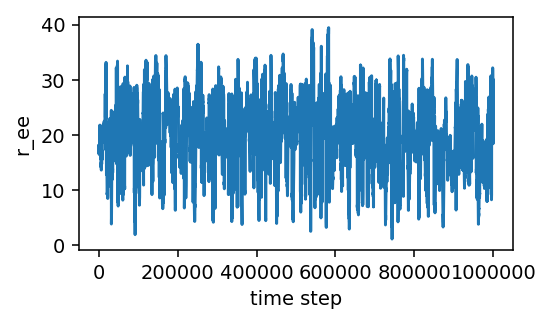

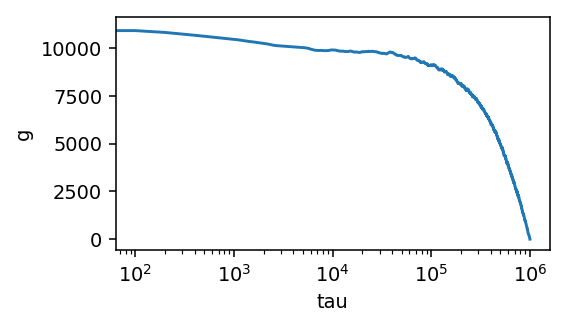

In [6]:
from matplotlib import pyplot
%matplotlib inline
#!head ree.log
data = numpy.genfromtxt(fname='ree.log',skip_header=True);
t=numpy.ndarray.flatten(data[:,0])
r_ee=data[:,1:]#/(101*(0.84**2))
print(numpy.shape(r_ee))
pyplot.figure(figsize=(4,2.2), dpi=140);
#pyplot.plot(t,r_ee);
for i in range(n_poly):
    pyplot.plot(t,r_ee[:,i]);
pyplot.xlabel('time step');
pyplot.ylabel('r_ee');
#r_ee=r_ee[len(r_ee)/2:]
def autocorr(x):
    result = numpy.correlate(x, x, mode='full')/(numpy.average(x)**2)-1.0
    return result[result.size/2:]
pyplot.figure(figsize=(4,2.2), dpi=140);
for i in range(n_poly):
    g=autocorr(numpy.ndarray.flatten(r_ee[:,i]))
    pyplot.semilogx(t,g)
pyplot.xlabel('tau');
pyplot.ylabel('g');

The results of this example may be visualized with VMD which can be installed from here: http://www.ks.uiuc.edu/Research/vmd/

In [7]:
#!vmd -e vdw.vmd gsd/random_polymer_loop.gsd

![](snapshots/random_polymer_loop.png)

In [8]:
!echo $PATH

/anaconda/bin:/usr/local/cuda/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/opt/X11/bin:/opt/local/bin:/opt/local/sbin:NVIDIA_CUDA-8.0_Samples/bin/x86_64/darwin/release/:/Users/mattferguson/bin:/anaconda/bin
